# Image classification with neural networks

In this problem, you will train a neural network to classify satellite images. In the data/EuroSAT_RGB directory, you will find 10 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

* overall test-set accuracy, measured however you think is appropriate
* show some of the example images from the test set, together with your model's predicted classes.
* a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

### Import libraries

In [35]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Load, normalize, and split data 80/20

In [37]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('data/EuroSAT_RGB', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Build a convolutional neural network

This SimpleCNN consists of three convolutional layers (conv1, conv2, and conv3) with increasing filter sizes, each followed by a max pooling layer to reduce spatial dimensions. After the convolutional layers, the output is flattened and passed through three fully connected layers (fc1, fc2, and fc3). The final output layer has 10 units, corresponding to the 10 EuroSAT land use classes. The network uses ReLU activation for intermediate layers and outputs raw scores (logits) for classification.

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

### Train the model

The training loop for the CNN uses the Adam optimizer and a cross-entropy loss function. It iterates through the data over 10 epochs, and prints average loss for each epoch.

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

Epoch 1, Loss: 1.0133
Epoch 2, Loss: 0.6145
Epoch 3, Loss: 0.4350
Epoch 4, Loss: 0.3210
Epoch 5, Loss: 0.2237
Epoch 6, Loss: 0.1489
Epoch 7, Loss: 0.1137
Epoch 8, Loss: 0.0875
Epoch 9, Loss: 0.0848
Epoch 10, Loss: 0.0676


### Evaluate model on test set

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test set accuracy: {accuracy*100:.2f}%')

Test set accuracy: 85.61%


### Create confusion matrix

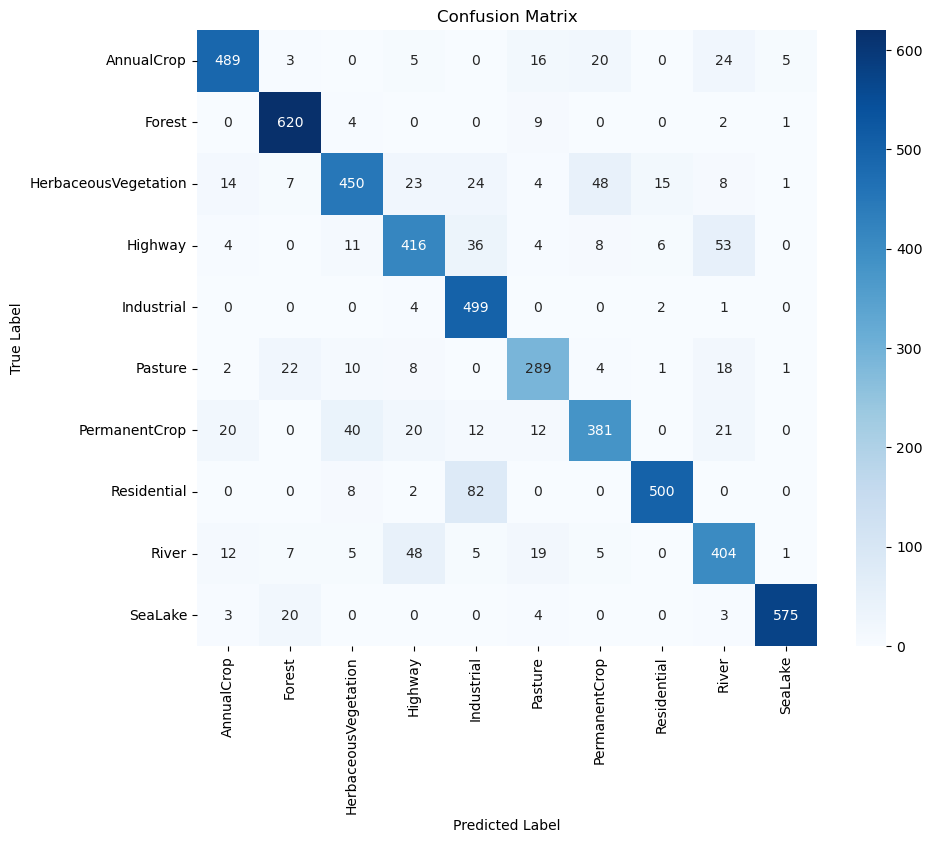

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Example images

Show some of the example images from the test set, together with the model's predicted classes.

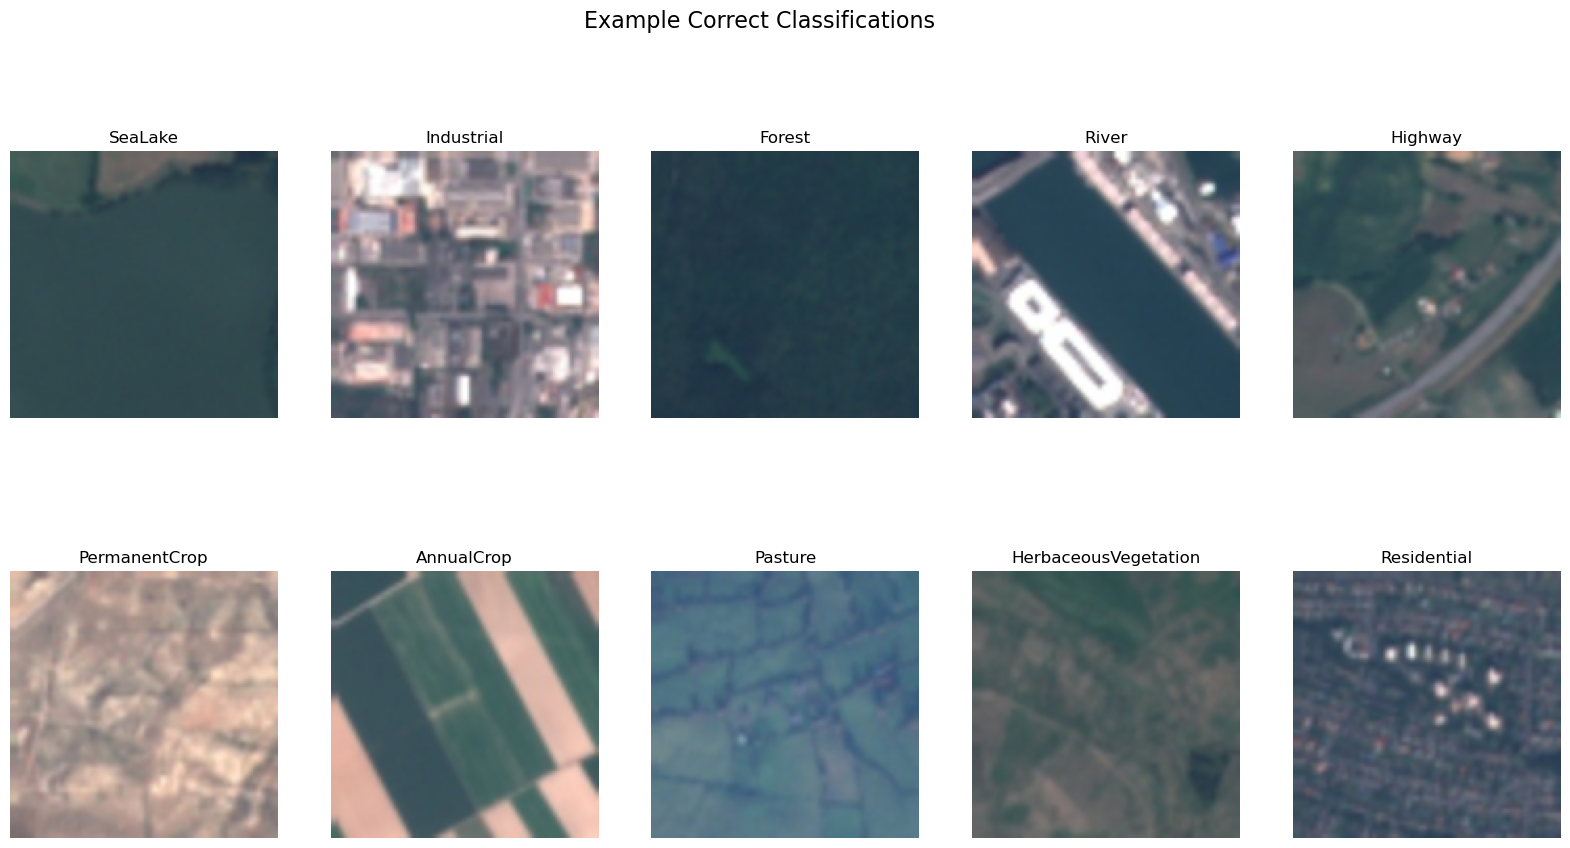

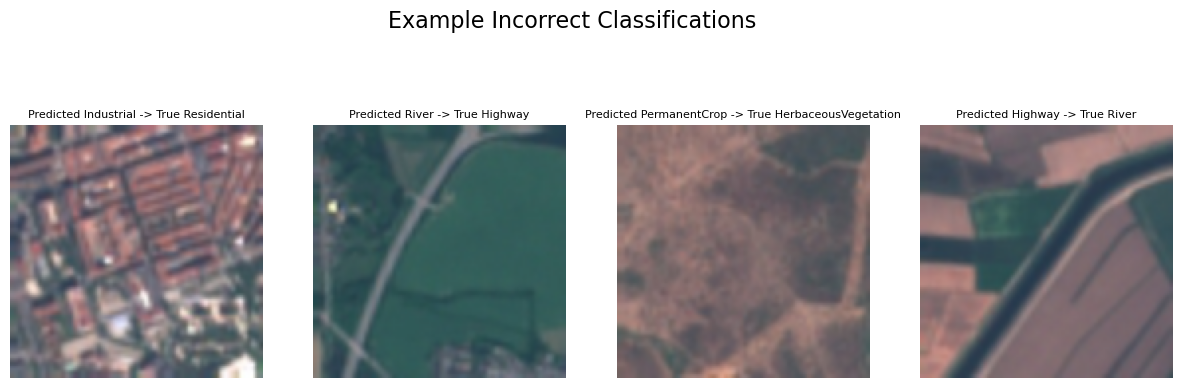

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Define the specific incorrect cases based on confusion matrix
case_conditions = {
    ('Industrial', 'Residential'): 'Predicted Industrial_True Residential',
    ('River', 'Highway'): 'Predicted River_True Highway',
    ('PermanentCrop', 'HerbaceousVegetation'): 'Predicted PermanentCrop_True HerbaceousVegetation',
    ('Highway', 'River'): 'Predicted Highway_True River'
}

correct_per_class = {}
incorrect_cases = {desc: None for desc in case_conditions.values()}

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            true_label = labels[i].item()
            predicted_label = preds[i].item()
            image = images[i].permute(1, 2, 0).cpu().numpy()
            image = np.clip(image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

            # Save correct classification
            if true_label == predicted_label and dataset.classes[true_label] not in correct_per_class:
                correct_per_class[dataset.classes[true_label]] = image

            # Save specific incorrect cases
            for (pred, true), desc in case_conditions.items():
                if true_label == dataset.class_to_idx[true] and predicted_label == dataset.class_to_idx[pred] and incorrect_cases[desc] is None:
                    incorrect_cases[desc] = image
                    break

            # Break early if all required images are collected
            if len(correct_per_class) == len(dataset.classes) and all(v is not None for v in incorrect_cases.values()):
                break

# Plot correct classifications
plt.figure(figsize=(20, 10))
plt.suptitle('Example Correct Classifications', fontsize=16)
for idx, (class_name, image) in enumerate(correct_per_class.items()):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.show()

# Plot incorrect cases
plt.figure(figsize=(15, 5))
plt.suptitle('Example Incorrect Classifications', fontsize=16)
for idx, (description, image) in enumerate(incorrect_cases.items()):
    if image is not None:
        plt.subplot(1, len(incorrect_cases), idx + 1)
        plt.imshow(image)
        plt.title(description.replace('_', ' -> '), fontsize=8)
        plt.axis('off')
plt.show()